# Signal Decomposition

[Time series signal decomposition](https://en.wikipedia.org/wiki/Decomposition_of_time_series) involves breaking down an original time series into its constituent components. By decomposing the time series, we can gain insights into underlying patterns, trends-cycles, and seasonal effects, enabling improved understanding and forecasting accuracy.

This notebook will show how to use the NHITS most to extract these series' components. We will:<br>
- Installing NeuralForecast.<br>
- Simulate a Harmonic Signal.<br>
- NHITS' decomposition.<br>

You can run these experiments using GPU with Google Colab.

<a href="https://colab.research.google.com/github/Nixtla/neuralforecast/blob/main/nbs/examples/Signal_Decomposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Installing NeuralForecast.

In [ ]:
%%capture
!pip install git+https://github.com/Nixtla/neuralforecast.git

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"]=True

from neuralforecast.models import NHITS
from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import HuberLoss, MQLoss

## 2. Simulate a Harmonic Signal.

In this example, we will consider a Harmonic signal comprising two frequencies: one low-frequency and one high-frequency.

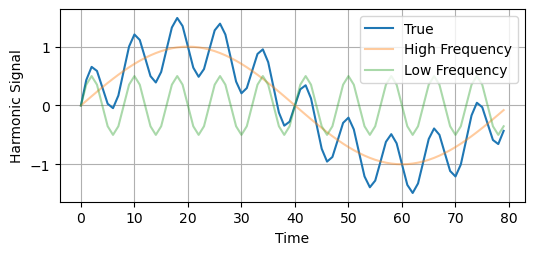

In [ ]:
N = 10_000
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N, endpoint=False)

y1 = np.sin(10.0 * 2.0*np.pi*x) 
y2 = 0.5 * np.sin(100 * 2.0*np.pi*x)
y = y1 + y2

fig, ax = plt.subplots(figsize=(6, 2.5))
plt.plot(y[-80:], label='True')
plt.plot(y1[-80:], label='High Frequency', alpha=0.4)
plt.plot(y2[-80:], label='Low Frequency', alpha=0.4)
plt.ylabel('Harmonic Signal')
plt.xlabel('Time')
plt.legend()
plt.show()
plt.close()

In [ ]:
# Split dataset into train/test
# Last horizon observations for test
horizon = 80
Y_df = pd.DataFrame(dict(unique_id=1, ds=np.arange(len(x)), y=y))
Y_train_df = Y_df.groupby('unique_id').head(len(Y_df)-horizon).reset_index()
Y_test_df = Y_df.groupby('unique_id').tail(horizon).reset_index()
Y_test_df

,index,unique_id,ds,y
0,9920,1,9920,2.156765e-13
1,9921,1,9921,4.320125e-01
2,9922,1,9922,6.564345e-01
3,9923,1,9923,5.869988e-01
4,9924,1,9924,3.090170e-01
...,...,...,...,...
75,9995,1,9995,-2.913004e-02
76,9996,1,9996,-3.090170e-01
77,9997,1,9997,-5.869988e-01
78,9998,1,9998,-6.564345e-01


## 3. NHITS decomposition.

We will employ NHITS' stack-specialization to recover the latent harmonic functions. 

NHITS, a Wavelet-inspired algorithm, allows for breaking down a time series into various scales or resolutions, aiding in the identification of localized patterns or features. The expressivity ratios for each layer enable control over the model's stack specialization.

In [ ]:
%%capture
models = [NHITS(h=horizon,                           # Forecast horizon
                input_size=2 * horizon,              # Length of input sequence
                loss=HuberLoss(),                    # Robust Huber Loss
                max_steps=3000,                      # Number of steps to train
                dropout_prob_theta=0.5,
                interpolation_mode='nearest',
                stack_types=['identity']*2,
                n_blocks=[1, 1],
                mlp_units=[[64, 64],[64, 64]],
                n_freq_downsample=[10, 1],           # Inverse expressivity ratios for NHITS' stacks specialization
                val_check_steps=10,                  # Frequency of validation signal (affects early stopping)
              )
          ]
nf = NeuralForecast(models=models, freq='M')
nf.fit(df=Y_train_df)

Global seed set to 1


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.56it/s]


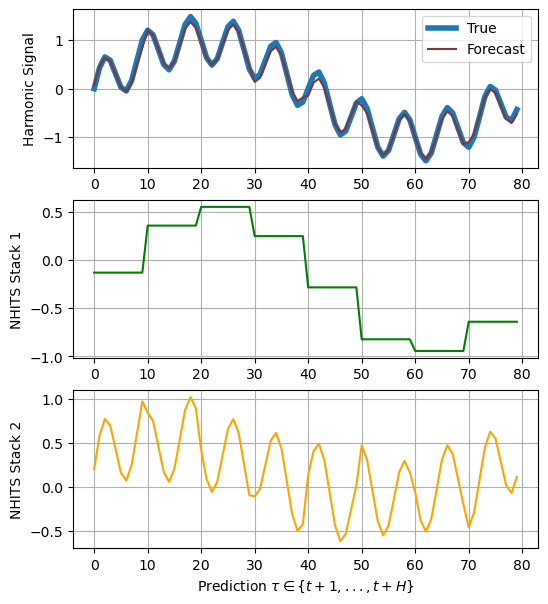

In [ ]:
from neuralforecast.tsdataset import TimeSeriesDataset

# NHITS decomposition plot
model = nf.models[0]
dataset, *_ = TimeSeriesDataset.from_df(df = Y_train_df)
y_hat = model.decompose(dataset=dataset)

fig, ax = plt.subplots(3, 1, figsize=(6, 7))

ax[0].plot(Y_test_df['y'].values, label='True', linewidth=4)
ax[0].plot(y_hat.sum(axis=1).flatten(), label='Forecast', color="#7B3841")
ax[0].legend()
ax[0].set_ylabel('Harmonic Signal')

ax[1].plot(y_hat[0,1]+y_hat[0,0], label='stack1', color="green")
ax[1].set_ylabel('NHITS Stack 1')

ax[2].plot(y_hat[0,2], label='stack2', color="orange")
ax[2].set_ylabel('NHITS Stack 2')
ax[2].set_xlabel(r'Prediction $\tau \in \{t+1,..., t+H\}$')
plt.show()

## References

- [Cristian Challu, Kin G. Olivares, Boris N. Oreshkin, Federico Garza, Max Mergenthaler-Canseco, Artur Dubrawski (2023). NHITS: Neural Hierarchical Interpolation for Time Series Forecasting. Accepted at AAAI 2023.](https://arxiv.org/abs/2201.12886)